#### **1) Libraries**

In [1]:
# !pip install -U tensorflow_probability -q

In [2]:
# prerequisites
import numpy as np
import math
import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set()
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, InputLayer, Lambda, Reshape, Dropout, \
                                    Flatten, Dense, Conv2D, Conv2DTranspose  
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import tensorflow_probability as tfp
from tensorflow_probability import distributions
# from tensorflow_probability.distributions import MultivariateStudentTLinearOperator
# from keras import objectives
from scipy.stats import norm

#### **2) MNIST Data**

Load the MNIST dataset

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Select a VAE Type, whether Variantional Autoencoder or Convolutional Variantional Autoencoder


In [4]:
vae_type = 'VAE'

Preprocess image

In [5]:
def preprocess_images(images, vae_type_in='VAE'):
    if vae_type_in == 'VAE':
        # Shape it as (n, 784,)
        images = images.astype('float32') / 255.
        return images.reshape(images.shape[0], -1)
    else:
        # Shape it as (n, 28, 28, 1) 
        images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
        return np.where(images > .5, 1.0, 0.0).astype('float32')

In [6]:
X_train = preprocess_images(X_train, vae_type_in=vae_type)
X_test = preprocess_images(X_test, vae_type_in=vae_type)
X_train.shape, X_test.shape

((60000, 784), (10000, 784))

In [7]:
train_dim = X_train.shape[1:]
train_dim

(784,)

#### **3) Encoder**

Set network parameters

In [8]:
batch_size = 100
n_epoch = 120
n_hidden = 1024
z_dim = 2

Encoder:

In [9]:
# Initializer imported from Cao code.  May do tuning here.
initializer = tf.keras.initializers.VarianceScaling(scale=0.1, mode='fan_in', distribution='normal')

In [10]:
# Activation functions require elu followed by tanh.
VAEEncoder = keras.Sequential(
    [
        Dense(n_hidden, activation='elu', kernel_initializer=initializer),
        Dropout(0.05),
        Dense(n_hidden//2, activation='elu', kernel_initializer=initializer),
        Dropout(0.05),
        Dense(n_hidden//4, activation='tanh', kernel_initializer=initializer),
        Dropout(0.05)
    ]
)

In [11]:
'''
CVAEEncoder = keras.Sequential(
    [
        Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='elu'),
        Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='tanh'),
        # Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
        # Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
        Flatten(),
        # No activation
        Dense(z_dim + z_dim)
    ]
)
'''

"\nCVAEEncoder = keras.Sequential(\n    [\n        Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='elu'),\n        Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='tanh'),\n        # Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),\n        # Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),\n        Flatten(),\n        # No activation\n        Dense(z_dim + z_dim)\n    ]\n)\n"

In [12]:
x = Input(shape=train_dim)
x_encoded = VAEEncoder(x) if vae_type == 'VAE' else CVAEEncoder(x)

#### **4) Latent Vector (*z*)**

In [13]:
if vae_type == 'VAE':
    mean_vector = Dense(z_dim, kernel_initializer=initializer)(x_encoded)  # mean vector
    log_std_vector = Dense(z_dim, kernel_initializer=initializer)(x_encoded)  # std vector
else:
    mean_vector, log_std_vector = tf.split(x_encoded, z_dim, axis=1)

# Stddev initially is log.  It gets called as an exponential when being sampled.
std_vector = 0.000001 + (log_std_vector)
print(mean_vector), print(std_vector)

Tensor("dense_3/BiasAdd:0", shape=(None, 2), dtype=float32)
Tensor("AddV2:0", shape=(None, 2), dtype=float32)


(None, None)

Sampling with the reparameterization trick

Reparameterization trick contains the following steps:

1.   Randomly sample ε from a unit Gaussian.
2.   Shift the randomly sampled ε by the latent distribution's mean μ and scale it by the latent distribution's variance σ.

In [14]:
# sampling function.  Function names have been cleaned up.
'''
def sampling(args):
    mean_vector, std_vector = args
    # Reparameterization trick
    epsilon = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
    return mean_vector + K.exp(std_vector) * epsilon

# z is the latent vector to be fed into 
z = Lambda(sampling, output_shape=(z_dim,))([mean_vector, std_vector])
'''

'\ndef sampling(args):\n    mean_vector, std_vector = args\n    # Reparameterization trick\n    epsilon = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)\n    return mean_vector + K.exp(std_vector) * epsilon\n\n# z is the latent vector to be fed into \nz = Lambda(sampling, output_shape=(z_dim,))([mean_vector, std_vector])\n'

TO DO: Find params that tunes of Kurtosis or heavier tails, noise to prevent bias and introduce variance, a type of regularization technique ...

- df is a positive scalar.
- loc is a vector in R^k,
- Sigma is a positive definite shape' matrix inR^{k x k}, parameterized asscale - @ scale.T` in this class,
- Z denotes the normalization constant, and,
- ||y||**2 denotes the squared Euclidean norm of y.

Link: https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/MultivariateStudentTLinearOperator

In [15]:
z_dim, batch_size

(2, 100)

In [16]:
coupling_dist = 0.01  # nonlinear coupling of distribution (>= 0)

In [17]:
# sampling function. Function names have been cleaned up.

def sampling(args):
    mean_vector, std_vector = args
    mvt = distributions.MultivariateStudentTLinearOperator(df=1/coupling_dist,
                                                           loc=np.zeros(z_dim),
                                                           # scale=np.identity(z_dim)
                                                           scale=tf.linalg.LinearOperatorLowerTriangular(np.identity(z_dim))
                                                           )
    # Modify epsilon to sample from Coupled-gaussians instead of Gaussians.
    epsilon = mvt.sample(sample_shape=(batch_size))
    epsilon = tf.dtypes.cast(epsilon, tf.float32)
    return mean_vector + K.exp(std_vector) * epsilon

z = Lambda(sampling, output_shape=(z_dim,))([mean_vector, std_vector])

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


#### **5) Decoder**

Decoder:

In [18]:
# Decoder.  Following convention from Cao code, it has VarianceScaling, along with activation functions tanh,
# elu, and sigmoid.  Also imported dropout following convention.
initializer = tf.keras.initializers.VarianceScaling(scale=0.1, mode='fan_in', distribution='normal')

In [19]:
VAEDecoder = keras.Sequential(
    [
        Dense(n_hidden//4, activation='tanh', kernel_initializer=initializer),
        Dropout(0.05),
        Dense(n_hidden//2, activation='elu', kernel_initializer=initializer),
        Dropout(0.05),
        Dense(n_hidden, activation='elu', kernel_initializer=initializer),
        Dropout(0.05),
        Dense(X_train.shape[1], activation='sigmoid', kernel_initializer=initializer)
    ]
)

In [20]:
'''
CVAEDecoder = keras.Sequential(
    [
        Dense(units=7*7*32, activation=tf.nn.relu),
        Reshape(target_shape=(7, 7, 32)),
        Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='elu'),
        Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='tanh'),
        # Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'),
        # Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
        # No activation
        Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same', activation='sigmoid')
        # Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same')
    ]
)
'''

"\nCVAEDecoder = keras.Sequential(\n    [\n        Dense(units=7*7*32, activation=tf.nn.relu),\n        Reshape(target_shape=(7, 7, 32)),\n        Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='elu'),\n        Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='tanh'),\n        # Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'),\n        # Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),\n        # No activation\n        Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same', activation='sigmoid')\n        # Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same')\n    ]\n)\n"

In [21]:
y = VAEDecoder(z) if vae_type == 'VAE' else CVAEDecoder(z)
y = tf.clip_by_value(y, 1e-8, 1 - 1e-8)

#### **6) Loss Function**

KL_d1 = entrpoy from original
KL_d1 = entrpoy from reduced dimensions

two loss:
- marginal likelihood (reconstruction loss)
- entropy loss


In [22]:
coupling_loss = 0.2
d = 20  # What is d?
d1 = 1 + d*coupling_loss + 2*coupling_loss  # What is d1?

In [23]:
d, d1

(20, 5.4)

In [24]:
#### Latent loss and image loss for Coupled VAE.
marginal_likelihood = tf.reduce_sum(x * tf.subtract(tf.pow(y, (2*coupling_loss) / (1 + coupling_loss)), 1) / (2*coupling_loss) + (1 - x)
                                    * tf.subtract(tf.pow(1 - y, (2 * coupling_loss) / (1 + coupling_loss)), 1) / (coupling_loss*2), 1)
KL_d1 = tf.reduce_prod(tf.pow(2 * tf.constant(math.pi), coupling_loss/(1 + d*coupling_loss)) * tf.sqrt(d1 / (d1 - 2*coupling_loss*tf.square(std_vector)))
                       * tf.exp(tf.square(mean_vector)*d1*coupling_loss / (1 + d*coupling_loss) / (d1 - 2*coupling_loss*tf.square(std_vector))), 1)
KL_d2 = tf.reduce_prod(tf.pow(2 * tf.constant(math.pi)*tf.square(std_vector),
                              coupling_loss / (1 + coupling_loss*d)) * tf.sqrt(d1 / (1 + d*coupling_loss)), 1)

KL_divergence = (KL_d1 - KL_d2) / coupling_loss / 2
marginal_likelihood = tf.reduce_mean(marginal_likelihood)

In [25]:
# loss
#reconstruction_loss = objectives.binary_crossentropy(x, y) * X_train.shape[1]
#kl_loss = 0.5 * K.sum(K.square(mu) + K.exp(log_var) - log_var - 1, axis = -1)
ELBO = marginal_likelihood - KL_divergence
vae_loss = -ELBO
vae_loss

<tf.Tensor 'Neg:0' shape=(None,) dtype=float32>

#### **7) Model Train**

In [26]:
# build model
vae = Model(x, y)
vae.add_loss(vae_loss)
opt = keras.optimizers.Adam(learning_rate=1e-3)
vae.compile(optimizer=opt)
vae.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 256)          1459968     input_1[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 2)            514         sequential[0][0]                 
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            514         sequential[0][0]                 
_______________________________________________________________________________________

Train model:

In [27]:
vae.fit(X_train,
        shuffle=True,
        epochs=n_epoch,
        batch_size=batch_size,
        validation_data=(X_test, None),
        verbose=1
        )

Epoch 1/120
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
600/600 [==============================] - 3s 6ms/step - loss: 132.4669 - val_loss: 113.4042
Epoch 2/120
600/600 [==============================] - 3s 5ms/step - loss: 110.6952 - val_loss: 106.0300
Epoch 3/120
600/600 [==============================] - 3s 5ms/step - loss: 106.1220 - val_loss: 103.3580
Epoch 4/120
600/600 [==============================] - 3s 5ms/step - loss: 103.9498 - val_loss: 101.8160
Epoch 5/120
600/600 [==============================] - 3s 5ms/step - loss: 102.6173 - val_loss: 100.9642
Epoch 6/120
600/600 [==============================] - 3s 5ms/step - loss: 101.8712 - val_loss: 99.5723
Epoch 7/120
600/600 [==============================] - 3s 5ms/step - loss: 101.2903 - val_loss: 98.8148
Epoch 8/120
600/600 [==============================] - 3s 5ms/step - loss: 100.6855 - val_loss: 98.7770
Epoch 9/120
600/600 [========================

#### **8) Model Plot**

In [28]:
# build encoder
encoder = Model(x, mean_vector)
encoder.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 256)               1459968   
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 514       
Total params: 1,460,482
Trainable params: 1,460,482
Non-trainable params: 0
_________________________________________________________________


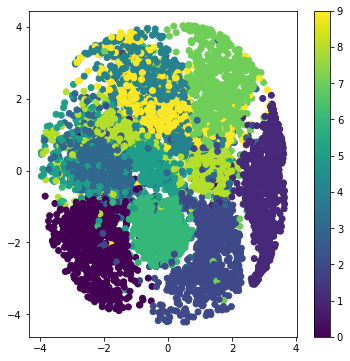

In [29]:
# Plot of the digit classes in the latent space
X_test_latent = encoder.predict(X_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(X_test_latent[:, 0], X_test_latent[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [30]:
# build decoder
decoder_input = Input(shape=(z_dim,))
_y = VAEDecoder(decoder_input) if vae_type == 'VAE' else CVAEDecoder(decoder_input)
generator = Model(decoder_input, _y)
generator.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 784)               1461264   
Total params: 1,461,264
Trainable params: 1,461,264
Non-trainable params: 0
_________________________________________________________________


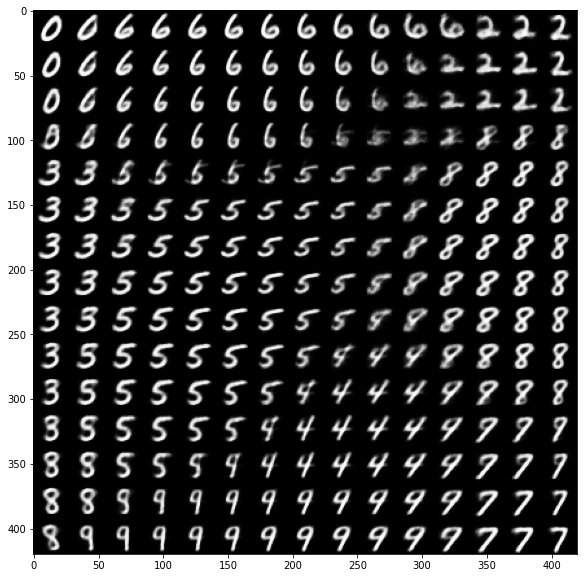

In [31]:
# display a 2D manifold of the digits
n = 15 # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) 
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

In [32]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) 
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

overall_values = []
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        for k in x_decoded:
          for m in k:
            overall_values.append(m)

In [33]:
print(overall_values[0:1000])

[4.2144642e-11, 8.292084e-11, 6.726171e-11, 3.565082e-11, 2.8815677e-11, 9.159159e-11, 5.2102867e-11, 3.7885008e-11, 4.0879165e-11, 5.7472218e-11, 6.782054e-11, 5.872122e-11, 2.6393508e-12, 8.0523105e-10, 2.8371813e-10, 7.0499474e-11, 4.768705e-11, 4.340771e-11, 6.53317e-11, 3.4867834e-11, 6.1504815e-11, 4.6822893e-11, 4.9230182e-11, 5.1396453e-11, 6.214525e-11, 5.0881542e-11, 4.1213928e-11, 2.554223e-11, 4.4561188e-11, 7.1842254e-11, 5.7032795e-11, 4.847304e-11, 8.0156375e-11, 1.206114e-13, 8.036415e-10, 1.3112172e-08, 1.1130766e-08, 1.3974189e-08, 2.796748e-08, 1.1652082e-07, 4.4676906e-08, 7.3872215e-08, 2.7549698e-08, 6.191911e-07, 5.8245723e-07, 3.0597195e-07, 8.693338e-07, 3.8292188e-07, 1.9916016e-07, 5.9749623e-09, 3.05466e-08, 9.523319e-09, 6.6211966e-11, 5.887565e-11, 3.8739432e-11, 7.7780817e-11, 8.388788e-11, 6.227731e-11, 6.575371e-12, 1.02799266e-13, 3.820127e-09, 7.6039375e-10, 3.1272187e-08, 1.6330353e-07, 2.9075431e-07, 4.2264534e-07, 1.4786813e-06, 5.099348e-06, 2.100

#### **9) Histogram**

In [34]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from math import log
from math import exp

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [35]:
log_overall_values = [log(record) for record in overall_values]

In [36]:
def calculateAccuracy(myList) : 
      
    # Multiply elements one by one 
    result = 1
    for x in myList: 
         temp = x ** (1/float(len(overall_values))) 
         result = result * temp
    #result = result ** (1/float(len(overall_values)))
    return result 

In [37]:
def calculateRobustness(myList):
  result = 0
  for x in myList:
    result = result + (x ** (-2/3))

  result = (result / float(len(myList))) ** (-3/2)
  return result

In [38]:
decisiveness = sum(overall_values) / float(len(overall_values))
accuracy = calculateAccuracy(overall_values)
robustness = calculateRobustness(overall_values)

In [39]:
print(robustness)

1.2737543714360881e-11


In [40]:
log_decisiveness = log(decisiveness)
log_accuracy = log(accuracy)
log_robustness = log(robustness)

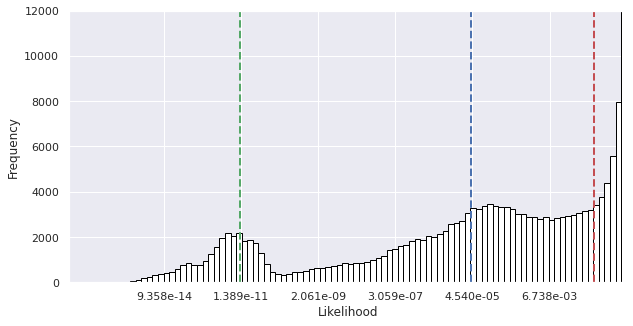

In [67]:
# the histogram of the data
#n, bins, patches = plt.hist(log_overall_values, 100, facecolor='green')
overall_values.sort()
log_overall_values.sort()
fig, ax = plt.subplots(figsize=(10,5))
ax.hist(log_overall_values, 100, facecolor='white', edgecolor='black') # `align='left'` is used to center the labels
xtick_labels = ["{:0.3e}".format(exp(f)) for f in [-30,-25,-20,-15,-10,-5,0]]
ax.set_xticks([-30,-25,-20,-15,-10,-5,0])
ax.set_xticklabels(xtick_labels)
plt.xlabel('Likelihood')
plt.ylabel('Frequency')
plt.axis([log_overall_values[0], log_overall_values[-1], 0, 12000])
plt.axvline(log_decisiveness, color='r', linestyle='dashed', linewidth=2)
plt.axvline(log_accuracy, color='b', linestyle='dashed', linewidth=2)
plt.axvline(log_robustness, color='g', linestyle='dashed', linewidth=2, label='dd')
plt.show();